In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from CustomPreprocessor import CustomPreprocessor
import seaborn as sns

Random Forest model loaded successfully.
SVM model loaded successfully.
Raw dataset loaded successfully.
Raw data sample:
               Name  Year  Student Number  Subject_1  Subject_2  Subject_3  \
0   Michael Thomas     1        24427517       1.25       3.00       2.25   
1  Michael Mcguire     4        21908695       1.75       2.00       2.75   
2   Jonathan Smith     4        21620116       1.00       1.75       2.50   
3     Jaime Phelps     2        23128726       1.25       2.50       4.00   
4  Nicole Hamilton     3        22926109       1.25       3.00       4.00   

   Subject_4  Subject_5     Status  Subject_6  Subject_7  Subject_8  \
0       1.50        1.0    Regular        NaN        NaN        NaN   
1       3.00        1.5    Regular        NaN        NaN        NaN   
2       1.75        2.0    Regular        NaN        NaN        NaN   
3       5.00        1.0  Irregular       2.75       2.25        1.0   
4       1.25        2.0  Irregular       4.00       2.25   

c:\Users\ChiliCheeze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


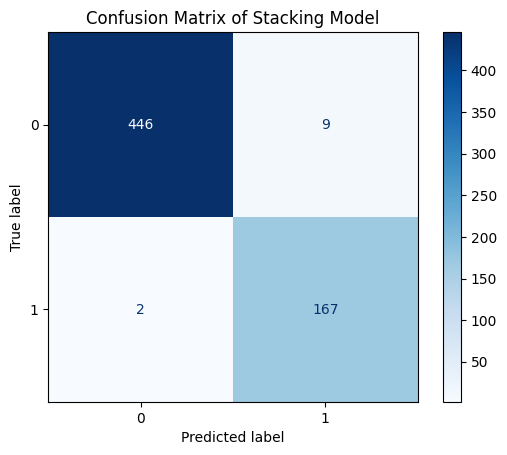

Accuracy: 0.982, Precision: 0.949, Recall: 0.988, F1 Score: 0.968
Meta-model saved successfully.

Base Model Weights in Meta-Model:
                 Base Model    Weight
0  Random Forest Prediction  0.798346
1            SVM Prediction  6.003823


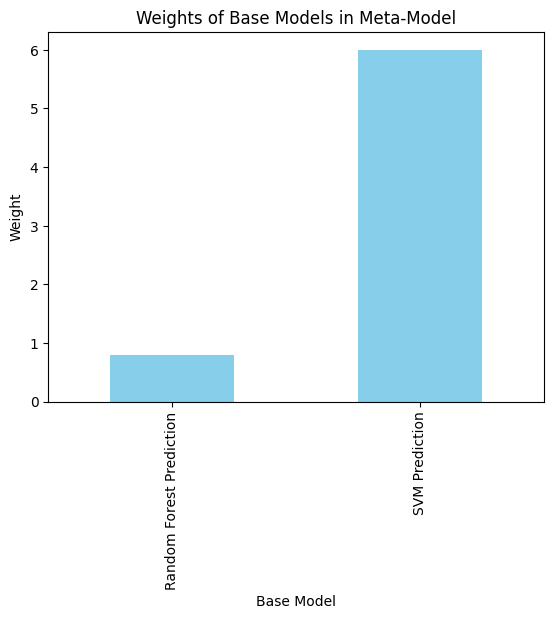


Predicting new data...
Test dataset 'test.csv' loaded successfully.
Test data sample:
               Name  Year  Student Number  Subject_1  Subject_2  Subject_3  \
0  Timothy Bridges     4        21034704       1.00       4.00       1.75   
1     Shane Fields     1        24496191       4.00       5.00       2.00   
2       Troy Scott     2        23895285       3.00       1.25       2.00   
3     Jeff Chapman     4        21811995       2.25       5.00       1.25   
4  Michael Collier     4        21532971       2.00       1.25       1.25   

   Subject_4  Subject_5  Subject_6  Subject_7  Subject_8  Final Grade  \
0       5.00       2.50        NaN        NaN        NaN         2.85   
1       2.25       5.00        NaN        NaN        NaN         3.62   
2       2.00       2.25        1.5       1.75        1.5         1.86   
3       4.00       1.75        NaN        NaN        NaN         2.85   
4       2.75       2.50        NaN        NaN        NaN         1.95   

   Subject

c:\Users\ChiliCheeze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\ChiliCheeze\AppData\Local\Temp\ipykernel_30508\3451896352.py:157: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_labels = true_labels.replace(label_mapping).values


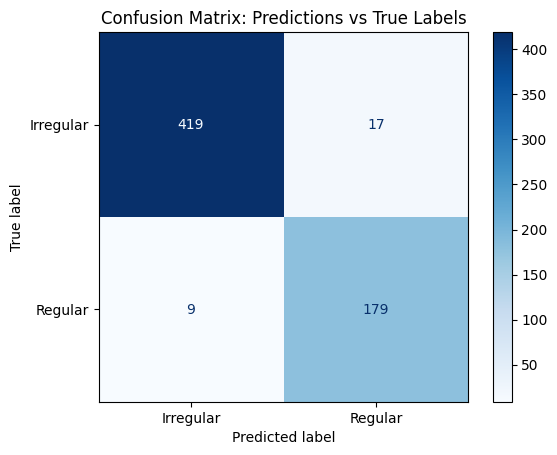

C:\Users\ChiliCheeze\AppData\Local\Temp\ipykernel_30508\3451896352.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='Correct', y='Count', palette=['green', 'red'])


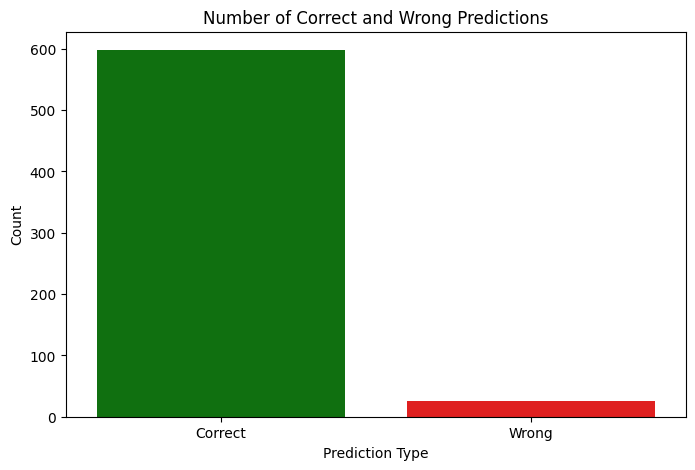

In [2]:
# Function to load models
def load_model(filepath, model_name):
    try:
        with open(filepath, 'rb') as file:
            model = pickle.load(file)
        print(f"{model_name} model loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading {model_name} model:", e)
        exit()

# Function to get predictions from a model
def get_model_predictions(model, X):
    try:
        return model.predict(X).reshape(-1, 1)
    except Exception as e:
        print(f"Error during predictions with {model}:", e)
        return None

# Function to preprocess data
def preprocess_data(filepath, preprocessor):
    try:
        raw_data = pd.read_csv(filepath)
        print("Raw dataset loaded successfully.")
        print("Raw data sample:\n", raw_data.head())

        processed_data = preprocessor.fit_transform(raw_data)
        print("Data preprocessing complete.")
        print("Columns in processed dataset:", processed_data.columns)

        # Split features and target
        X = processed_data.drop(columns=['Status']).values
        y = processed_data['Status'].values
        print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
        return X, y
    except FileNotFoundError:
        print(f"Error: File {filepath} not found.")
        exit()
    except Exception as e:
        print("Error during data preprocessing:", e)
        exit()

# Stacking ensemble function
def stacking_ensemble(X, y, rf_model, svm_model):
    try:
        # Generate predictions
        rf_preds = get_model_predictions(rf_model, X)
        svm_preds = get_model_predictions(svm_model, X)
        
        if rf_preds is None or svm_preds is None:
            print("Error: Predictions could not be obtained from base models.")
            return

        # Combine predictions for stacking
        stacked_features = np.hstack((rf_preds, svm_preds))
        print(f"Stacked features shape: {stacked_features.shape}")

        meta_model = LogisticRegression()
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        f1_scores = []
        y_true_all, y_pred_all = [], []

        # Cross-validation
        for train_idx, test_idx in kf.split(stacked_features):
            X_train, X_test = stacked_features[train_idx], stacked_features[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            meta_model.fit(X_train, y_train)
            y_pred = meta_model.predict(X_test)

            y_true_all.extend(y_test)
            y_pred_all.extend(y_pred)

            fold_f1 = f1_score(y_test, y_pred)
            print(f"Fold F1 Score: {fold_f1:.4f}")
            f1_scores.append(fold_f1)

        # Calculate and display overall metrics
        mean_f1 = np.mean(f1_scores)
        print(f"\nMean F1 Score of Stacking Model: {mean_f1:.4f}")

        conf_matrix = confusion_matrix(y_true_all, y_pred_all)
        print("Confusion Matrix:\n", conf_matrix)
        ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap='Blues')
        plt.title("Confusion Matrix of Stacking Model")
        plt.show()

        accuracy = accuracy_score(y_true_all, y_pred_all)
        precision = precision_score(y_true_all, y_pred_all)
        recall = recall_score(y_true_all, y_pred_all)
        print(f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {mean_f1:.3f}")

        # Save the meta-model
        with open('stacking_meta_model.pkl', 'wb') as meta_model_file:
            pickle.dump(meta_model, meta_model_file)
        print("Meta-model saved successfully.")

        if hasattr(meta_model, 'coef_'):
            weights = meta_model.coef_[0]  # Get coefficients for each base model
            base_model_names = ['Random Forest Prediction', 'SVM Prediction']

            # Display the weights
            weight_df = pd.DataFrame({
                'Base Model': base_model_names,
                'Weight': weights
            })

            print("\nBase Model Weights in Meta-Model:")
            print(weight_df)

            # Plot the weights
            weight_df.plot(kind='bar', x='Base Model', y='Weight', legend=False, color='skyblue')
            plt.title('Weights of Base Models in Meta-Model')
            plt.ylabel('Weight')
            plt.show()
        else:
            print("Meta-model does not have 'coef_' attribute.")

        return meta_model
    except Exception as e:
        print("Error in stacking ensemble:", e)
        return None


def predict_new_data(meta_model, rf_model, svm_model, test_data_path, preprocessor, true_labels_path=None):
    try:
        # Load test data
        test_data = pd.read_csv(test_data_path)
        print(f"Test dataset '{test_data_path}' loaded successfully.")
        print("Test data sample:\n", test_data.head())

        # Process test data
        processed_test_data = preprocessor.transform(test_data)
        X_test = processed_test_data.values

        # Get predictions from base models
        rf_preds = get_model_predictions(rf_model, X_test)
        svm_preds = get_model_predictions(svm_model, X_test)

        if rf_preds is None or svm_preds is None:
            print("Error: Predictions could not be obtained from base models.")
            return

        # Stack the base model predictions
        stacked_features_test = np.hstack((rf_preds, svm_preds))

        # Get final predictions from meta-model
        final_predictions = meta_model.predict(stacked_features_test)
        print("Predictions for the test dataset:", final_predictions)

        # Checking if the prediction result matches the original status of the students 
        if true_labels_path:
            true_labels = pd.read_csv(true_labels_path)['Status']
            
            # Map labels if necessary
            label_mapping = {'Regular': 1, 'Irregular': 0}  
            true_labels = true_labels.replace(label_mapping).values  
            
            print("Mapped true labels:", true_labels)  
            accuracy = accuracy_score(true_labels, final_predictions)
            print(f"Accuracy on new data: {accuracy:.3f}")

            # Print classification report
            report = classification_report(true_labels, final_predictions)
            print("Classification Report:\n", report)

            # Confusion Matrix Visualization
            conf_matrix = confusion_matrix(true_labels, final_predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Irregular', 'Regular'])
            disp.plot(cmap='Blues')
            plt.title("Confusion Matrix: Predictions vs True Labels")
            plt.show()

            comparison_df = pd.DataFrame({
                'Index': np.arange(len(true_labels)),
                'True Labels': true_labels,
                'Predictions': final_predictions
            })

            comparison_df['Correct'] = comparison_df['True Labels'] == comparison_df['Predictions']

            # Count correct and wrong predictions
            summary = comparison_df['Correct'].value_counts().reset_index()
            summary.columns = ['Correct', 'Count']
            summary['Correct'] = summary['Correct'].map({True: 'Correct', False: 'Wrong'})

            # Plot the results
            plt.figure(figsize=(8, 5))
            sns.barplot(data=summary, x='Correct', y='Count', palette=['green', 'red'])
            plt.title("Number of Correct and Wrong Predictions")
            plt.xlabel("Prediction Type")
            plt.ylabel("Count")
            plt.show()

        return final_predictions

    except FileNotFoundError:
        print(f"Error: Test data file '{test_data_path}' not found.")
        return None
    except Exception as e:
        print("Error during prediction:", e)
        return None



# Main script
if __name__ == "__main__":
    rf_model = load_model('RANDOM FOREST_GANS_25 convert.pkl', 'Random Forest')
    svm_model = load_model('SVM_Solo_woGans_convert.pkl', 'SVM')

    preprocessor = CustomPreprocessor()
    X, y = preprocess_data('raw_1.csv', preprocessor)

    print("\nRunning stacking ensemble...")
    meta_model = stacking_ensemble(X, y, rf_model, svm_model)

    print("\nPredicting new data...")
    predict_new_data(meta_model, rf_model, svm_model, 'test.csv', preprocessor, 'new_data.csv')




In [3]:
import nbformat
from nbconvert import PythonExporter

# Path to the Jupyter Notebook
input_notebook = 'stacking_model_2.ipynb'  
output_script = 'stacking_model.py' 

try:
    # Load the notebook content
    with open(input_notebook, 'r', encoding='utf-8') as f:
        notebook_content = nbformat.read(f, as_version=4)

    # Convert to Python script
    exporter = PythonExporter()
    python_script, _ = exporter.from_notebook_node(notebook_content)

    # Save the Python script
    with open(output_script, 'w', encoding='utf-8') as f:
        f.write(python_script)

    print(f"Notebook '{input_notebook}' successfully converted to '{output_script}'.")
except Exception as e:
    print(f"An error occurred during conversion: {e}")


Notebook 'stacking_model_2.ipynb' successfully converted to 'stacking_model.py'.
